<a href="https://colab.research.google.com/github/VodkaSin/Cell-segmentation-GUI-with-Cellpose/blob/main/290921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q tensorflow==2.6.0 tensorflow-gpu==2.6.0
!pip install -q gTTS
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 458.3 MB 11 kB/s 


# Library

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow_docs.vis import embed # What does this do?

import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt

from matplotlib.collections import LineCollection # What does this do?

import matplotlib.patches as patches # What does this do?

# Some modules to display an animation using imageio.
import imageio # What does this do?
import PIL
import io
import math
from IPython.display import display, Javascript, Image, HTML, Audio # When are all these used?
from gtts import gTTS
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode


# Visualization helper functions

In [16]:
# Capture frame in bytes from streaming
def take_frame(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [17]:
def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
    
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))

In [18]:
# JavaScript to create video stream from webcam
def start_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 192,192);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span></span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      video.style.cssText = "-moz-transform: scale(-1, 1); \
-webkit-transform: scale(-1, 1); -o-transform: scale(-1, 1); \
transform: scale(-1, 1); filter: FlipH;";
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 192; //video.videoWidth;
      captureCanvas.height = 192; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)


In [19]:
# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """ Used in main function to convert image types
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BRG image (mirror flipped)
  """
  # decode base64 image
  image_bytes = b64decode(js_reply['img'].split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  img = cv2.flip(img,1)

  return img

In [20]:
def drawing_array_to_bytes(image_array):
    """
    input: 
          drawing_array: image RGBA size 512 x 512 
                              contain bounding box and text from yolo prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array, use to modity img_data in js_reply
    """

    im_resize = cv2.resize(image_array, (192, 192))
    is_success, im_buf_arr = cv2.imencode(".jpg", im_resize)
    if is_success:
      byte_im = im_buf_arr.tobytes()
      drawing_bytes = 'data:image/png;base64,{}'.format((str(b64encode(byte_im))))

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Model loading
### Model description
Movenet is a convolutional neural network model that predicts human joint location running on RGB images of >30FPS (lightning). 

The input should be in the format of an int32 tensor 192x192x3, channel [0,255]

The output is a float32 tensor of shape [1,1,17,3], with the first two channels representing the y and x coordinate normalized in [0.0,1.0], the second denotes the index of the 17 keypoints of the order: 

[nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]

Lastly, the fourth channel [0.0,1.0] is the prediction confidence.


In [22]:
# Grab from TF hub and initialize interpreter
!wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3?lite-format=tflite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [23]:
# Main function
def image_to_keypoints(frame):
  """ Runs detection on an input frame
  Params:
          frame: 192x192 opencv BRG
  Returns:
          keypoints_with_scores: [index, location, confidence]
  """  
  # Reshape iamge to 192x192x3
  img = tf.image.resize_with_pad(np.expand_dims(frame, axis=0), 192,192)
  input_image = tf.cast(img, dtype=tf.float32) # Specify data type

  # Setup input and output 
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Make predictions 
  interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
  interpreter.invoke()
  keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
  return (keypoints_with_scores)

def movenet(frame,threshold):
  keypoints = image_to_keypoints(frame)
  draw_connections(frame, keypoints, EDGES, threshold)
  draw_keypoints(frame, keypoints, threshold)

## Render

In [24]:
# Dictionary that maps from joint names to keypoint indices.

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}


In [25]:
def draw_keypoints(frame, keypoints, array, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    points = []
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            array = cv2.circle(array, (int(kx), int(ky)), 4, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, array, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            array = cv2.line(array, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [26]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot


# Angle calculation

Based on cosine theorem. 6 nodes on each side (shoulder, elbow, wrist, hip, knee, ankle), choosing 3 from 6 are 20 combinations, among which the angles needed are: 

1. left/right shoulders (hip reference): hip, shoulder, elbow
2. left/right shoulders (shoulder reference): elbow, shoulder, shoulder
2. left/right elbows: shoulder, elbow, wrist  - direction determined by: wrist shoulder, hip
3. left/right torso: shoulder, hip, knees
4. left/right knees: hip, knees, ankle

Plus additional measures about the coordination between two sides:

1. Opening of the legs: hips, knees
2. Side crunch of torso: shoulders, hips
3. Turning of the torso: left shoulder, right shoulder, right hip; right shoulder, left shoulder, left hip

If there's is only upperbody, may use the lower border of the frame as hip direction (horizontal)



In [27]:
def getAngle(a, b, c):
    ang = abs(math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0])))
    return ang
print(getAngle((0,0),(1,5),(2,0)))


22.61986494804043


In [28]:
def getAngle2(a,b,c,d):
  dx = c[1]-a[1]
  dy = c[0]-a[0]
  return getAngle(b,a,(d[0]-dx,d[1]-dy))
print(getAngle2((1,5),(0,0),(3,7),(4,2)))

22.61986494804043


In [29]:
# Note that the image is flipped, here the keys refer to the user's pov
THREE_JOINT_INDEX = {
    'right_shoulder (H)': (11,5,7),
    'right_shoulder (S)': (7,5,6),
    'left_shoulder (H)': (12,6,8),
    'left_shoulder (S)': (8,6,5),
    'right_elbow':(5,7,9),
    'left_elbow':(6,8,10),
    'right_torso':(5,11,13),
    'left_torso':(6,12,14),
    'right_knee':(11,13,15),
    'left_knee':(12,14,16),
    'right_torso turn':(6,5,11),
    'left_torso_turn':(5,6,12)
}
FOUR_JOINT_INDEX ={
    'shoulders_hips':(5,6,11,12),
    'btw_legs':(11,13,12,14)
}

In [30]:
def find_angle_3(keypoints_with_scores, threshold=0.1):
  angles = {}
  for keys, indexs in THREE_JOINT_INDEX.items():
    a = []
    flag = True
    for i in indexs:
      if keypoints_with_scores[0][0][i][2]<threshold:
        flag = False
        break
      a.append((keypoints_with_scores[0][0][i][1],keypoints_with_scores[0][0][i][0]))
    if flag:
      angles[keys] = getAngle(a[0],a[1],a[2])
  return angles   
        

In [31]:
def find_angle_4(keypoints_with_scores, threshold=0.1):
  angles = {}
  for keys, indexs in FOUR_JOINT_INDEX.items():
    a = []
    flag = True
    for i in indexs:
      if keypoints_with_scores[0][0][i][2]<threshold:
        flag = False
        break
      a.append((keypoints_with_scores[0][0][i][1],keypoints_with_scores[0][0][i][0]))
    if flag:
      angles[keys] = getAngle2(a[0],a[1],a[2],a[3])
  return angles

In [33]:
# Test run
start_stream()
workout = 'Stand'
label_html = 'Smart Coach'  #label
img_data = ''
while True:
    js_reply = take_frame(label_html, img_data)
    if not js_reply:
      print('Streaming has been interupted')
      break
    # Process Javascript Object (frame) to OpenCV BRG
    image_array192 = js_to_image(js_reply)
    # Initialize render array
    img_array= np.zeros([192,192,4], dtype=np.uint8)
    # Run the interpreter on the BRG image
    keypoints_with_scores = image_to_keypoints(image_array192)
    # Calculate the angles between joints
    angles3 = find_angle_3(keypoints_with_scores)
    angles4 = find_angle_4(keypoints_with_scores)
    #Compare with instructions and voice out suggestions
    #suggestion_key = compare(workout, angles3, angles4)
    #tts = gTTS(SUGGESTIONS[workout][suggestion_key])
    #tts.save('1.wav')
    #sound_file = '1.wav'
    #Audio(sound_file, autoplay=True)
    # Rendering the keypoints and edges: add to img_array and convert to JS
    draw_keypoints(image_array192, keypoints_with_scores, img_array, 0.1)
    draw_connections(image_array192, keypoints_with_scores, EDGES, img_array, 0.1)
    img_array[:,:,3] = (img_array.max(axis = 2)>0).astype(int)*255
    img_data = bbox_to_bytes(img_array)

<IPython.core.display.Javascript object>

Streaming has been interupted


In [ ]:
SUGGESTIONS = {
    'General':['Keep up the good work!','Hang on there, 1 minute left!'],
    'Jump rope':['Keep your elbows tucked in!','Straighten your back','Keep your feet close together when jumping']
}

In [ ]:
ty = 'Jump rope'
tts = gTTS(SUGGESTIONS[ty][1])
tts.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

In [ ]:
angles3 = find_angle_3(keypoints_with_scores)
print(angles3)
angles4 = find_angle_4(keypoints_with_scores)
print(angles4)

# Video input


In [ ]:
video_path = 'work.mp4'

In [ ]:
video_path = "test.mp4"
record_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:test.mp4


In [ ]:
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video(video_path)

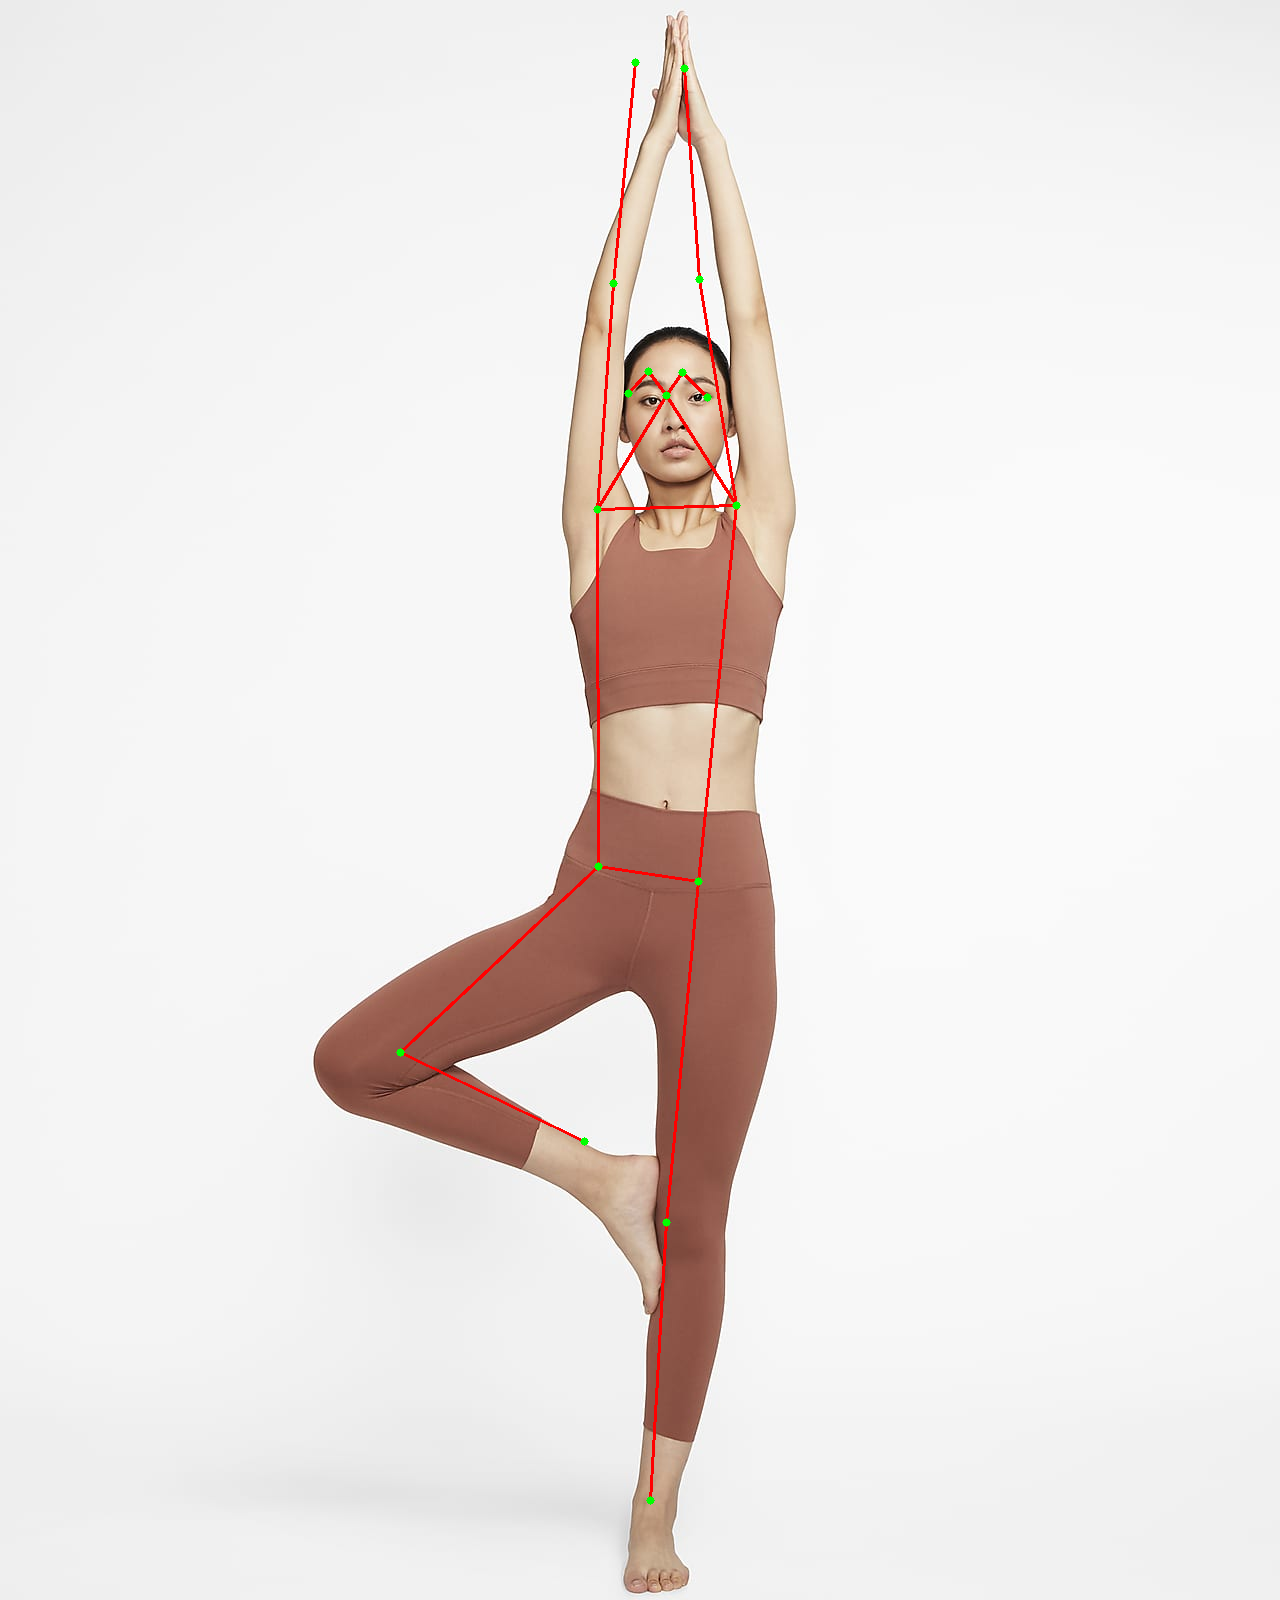

In [ ]:
cap = cv2.VideoCapture(video_path)
img = cv2.imread('yoga.jpegh.jfif')
#resized = cv2.resize(img, (500,500), interpolation = cv2.INTER_AREA)
resized = img.copy()
imgcopy = tf.image.resize_with_pad(np.expand_dims(resized, axis=0), 192,192)
input_image = tf.cast(imgcopy, dtype=tf.float32) # Specify data type
    
    # Setup input and output 
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
    
    # Make predictions 
interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    #print('Keypoints: ', keypoints_with_scores)
    
    # Rendering 
draw_connections(resized, keypoints_with_scores, EDGES, resized, 0.1)
draw_keypoints(resized, keypoints_with_scores,resized, 0.1)
    
cv2_imshow(resized)

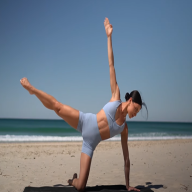

In [ ]:
img = cv2.imread('Picture1.png')
resized = cv2.resize(img, (192,192), interpolation = cv2.INTER_AREA)
cv2_imshow(resized)
